In [1]:
%load_ext autoreload
%autoreload 2

Chose device

In [2]:
device = 'cpu'

# outcomment to use GPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# device = 'cuda'


Demo showing how to calculate information content (IC) of audio files

In [3]:
from pa_audioic.audioic import ICCalcHelper, IntegrationParams
import numpy as np
import librosa
import matplotlib.pyplot as plt

Initialize the ICCalcHelper on a device using the provided checkpoint trained on multitrack music

In [4]:
ic_calc_helper = ICCalcHelper(device=device)

Input an audio-file or a numpy array containing a wav at 44100Hz. Choose the audio-type (music or voice)

In [5]:
librosa_files = ['trumpet', 'brahms']
audio_files = [librosa.ex(name) for name in librosa_files]
audio_type = 'music'
noise_levels = [0.0, 0.3, 0.5, 0.6, 0.9]
integration_params = IntegrationParams(solver='euler', solver_kwargs={'n_steps': 100}, n_runs=4)



In [6]:
heading_nan_pad, trailing_nan_padding, latents = zip(*[ic_calc_helper.encode_m2l(audio_file, silence_extractor=audio_type) for audio_file in audio_files])
nlls = ic_calc_helper.ic(heading_nan_pad, trailing_nan_padding, latents, noise_levels=noise_levels, integration_params=integration_params)
[nll.shape for nll in nlls]

[(5, 74), (5, 517)]

Plot resulting IC Curve

Since IC should be seen as relative to previous/future representations and is generally on different scales for different noise levels, normalize ICs for different noise levels to `min,max=0,1`. 

In [7]:
def visual_normalizer(x):
    """
    Normalize the input array x to the range [0, 1] for visualization purposes.
    """
    return (x - np.nanmin(x, axis=1, keepdims=True)) / (np.nanmax(x, axis=1, keepdims=True) - np.nanmin(x, axis=1, keepdims=True))

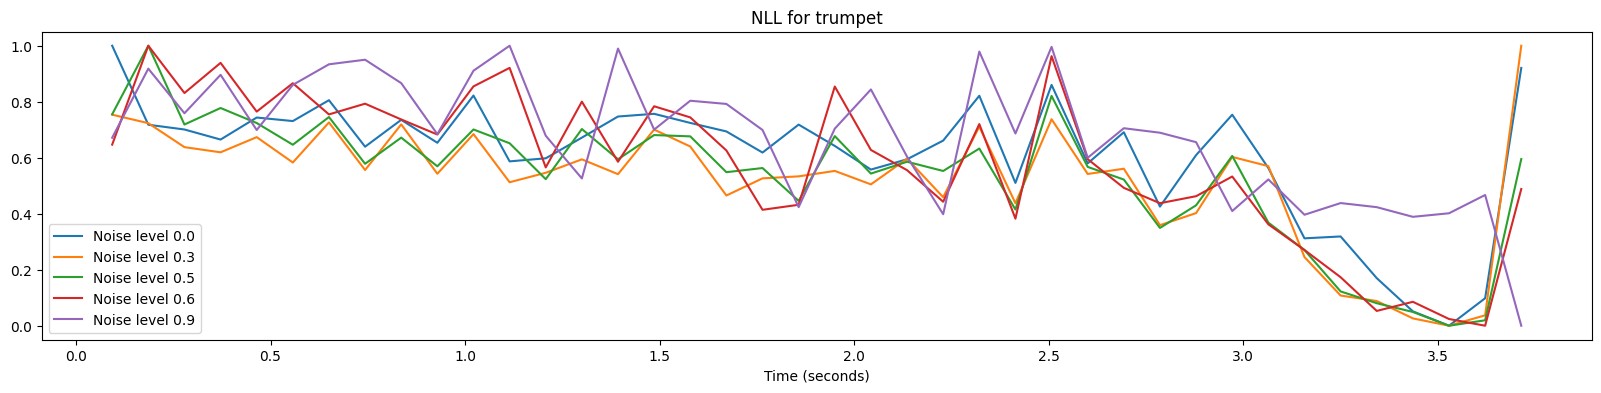

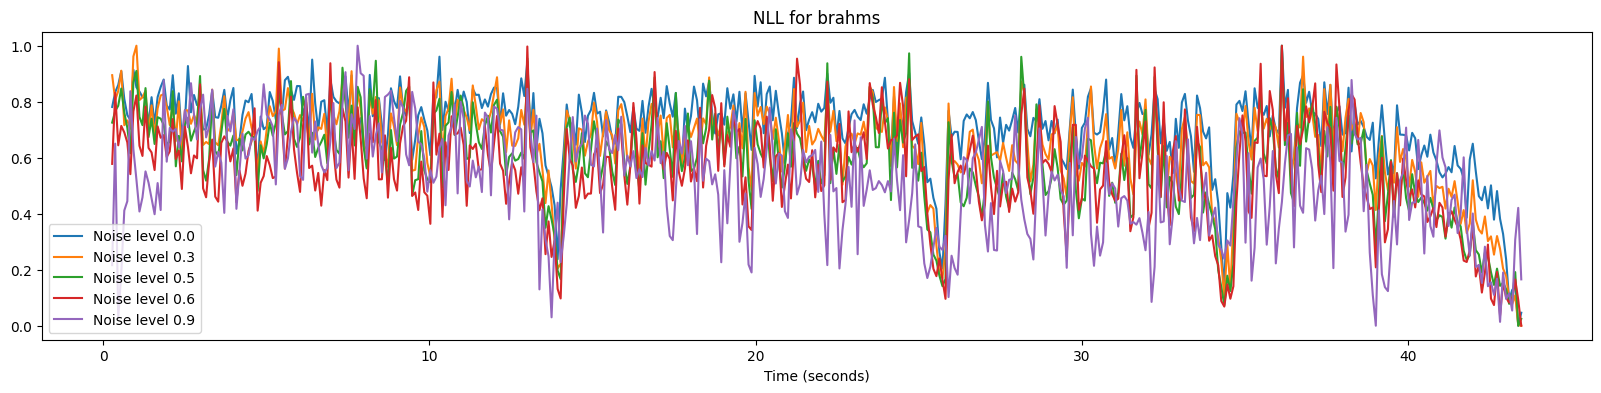

In [8]:
for name, nll in zip(librosa_files, nlls):
    plt.figure(figsize=(20,4))
    plt.title(f'NLL for {name}')
    time = ic_calc_helper.frames_to_time(nll.shape[1])
    plt.plot(time, visual_normalizer(nll).T, label=[f'Noise level {nl}' for nl in noise_levels])
    plt.legend()
    plt.xlabel('Time (seconds)')